
# Project 4: Churn Prediction Modelling 

---

In [9]:
import pandas as pd

data = r"/Users/meisan/Documents/GitHub/GA-DAT9-Projects1/R_Morgan_Project4_Files/telecom_data.csv"
df = pd.read_csv(data)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline

In [11]:
feature_names = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_calls','total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n',
                 'area_code_408','area_code_415','area_code_510']

predictors = ['account_length','total_intl_charge','number_customer_service_calls',
              'total_day_calls','area_code_408','area_code_415','area_code_510']

X = df[feature_names]
y = df['churn_n']


In [12]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

#### Use Smote-Tomek to resample data

In [13]:
#from collections import Counter
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_sample(Xs, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_samp = pd.DataFrame(X_res, columns = feature_names)
y_samp = pd.DataFrame(y_res, columns = ['churn_n'])

Original dataset shape Counter({0: 4293, 1: 707})
Resampled dataset shape Counter({0: 4285, 1: 4285})


In [7]:
X_samp.head()

,account_length,num_of_voice_mail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_n,area_code_408,area_code_415,area_code_510
0,0.698941,1.273145,0.502824,1.574074,-0.060077,-0.063849,-0.446928,0.876286,-0.584236,-0.095509,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
1,0.169849,1.346973,1.158422,-0.347082,0.141693,-0.101089,0.154374,1.069818,-0.584236,1.245982,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
2,0.925695,-0.572549,0.704546,1.171286,0.494791,-1.572084,0.204483,-0.746737,0.229917,0.695971,-1.202236,-0.323240,-0.580122,1.002002,-0.576119
3,-0.409634,-0.572549,-1.463971,2.210457,-0.614946,-2.745155,-0.547145,-0.069377,1.044069,-1.329681,0.328885,3.093675,1.723777,-0.998002,-0.576119
4,-0.636388,-0.572549,0.654116,-0.252115,1.100103,-1.034426,1.056327,-0.267307,-0.584236,-0.055264,1.094445,3.093675,-0.580122,1.002002,-0.576119


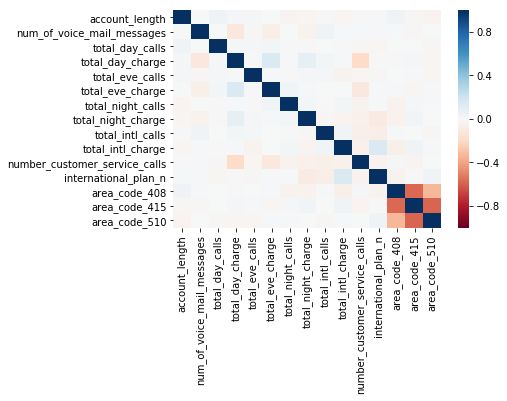

In [31]:
#get visual distributions of all metrics
sns.heatmap(X_samp.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

1. CRIM, ZN and RM do not have strong correlation, so we can use them as model features.

### Logisitic Regression Modelling

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# create training and testing vars, check shape
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6856, 15) (6856,)
(1714, 15) (1714,)


In [33]:
# Make an instance of a LinearRegression object.
lr = LogisticRegression()
type(lr)

sklearn.linear_model.logistic.LogisticRegression

In [34]:
# help(lr)


In [35]:
model = lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)

[-0.70770615]
[[ 0.0802099  -0.48152806  0.1272586   0.81748867  0.01558429  0.38409885
  -0.10692036  0.21415336 -0.18709153  0.25001661  0.90955716  0.69646474
  -0.00257573 -0.01770704  0.02305281]]


In [36]:
#assign array with predicted 'y' results to 'y_predicted'
y_pred = lr.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [37]:
y_pred_prob = lr.predict_proba(X_test)[:, 1]

In [52]:
lo_table = pd.DataFrame({'Probability':list(y_pred_prob),'Odds':list(y_pred_prob/(1-y_pred_prob))})
lo_table.shape

(1714, 2)

In [39]:
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred > .5)

array([[682, 173],
       [162, 697]])

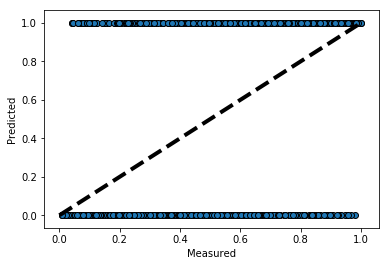

In [40]:
fig, ax = plt.subplots()
ax.scatter(y_pred_prob, y_test, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [41]:
#print accuracy score of model
print('Score:', model.score(X_test,y_test))
print('Score:', model.score(X_train,y_train))

Score: 0.8045507584597433
Score: 0.7850058343057176


In [42]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import metrics

n_scores = pd.DataFrame(columns=['no_folds','scores'])

In [43]:
scores = []
no_folds = []
for n in range(2,51):
    predicted = cross_val_predict(model, X_res, y_res, cv=n)
    score = metrics.accuracy_score(y_res, predicted)
    no_folds.append(n)
    scores.append(score)

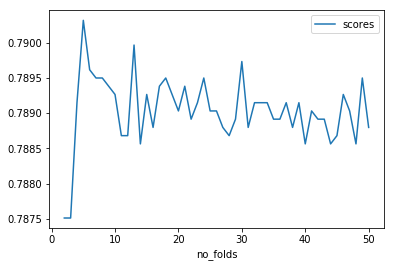

In [44]:
s = {'no_folds':no_folds, 'scores':scores}
n_scores = pd.DataFrame(s)
n_scores.plot('no_folds', 'scores')

In [45]:
from nltk import ConfusionMatrix 
print (ConfusionMatrix(list(y_res), list(predicted)))

  |    0    1 |
--+-----------+
0 |<3323> 962 |
1 |  848<3437>|
--+-----------+
(row = reference; col = test)



In [47]:
scores = []
for n in range(2,51):
    scores = cross_val_score(model, X_test, y_test, cv=n)
    print('--------{0}-fold stats --------'.format(n))
    print ('Cross-validated scores:', scores)
    print ('mean of {0}-fold CV scores: {1}'.format(n,np.mean(scores)))
    print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

--------2-fold stats --------
Cross-validated scores: [0.82517483 0.78971963]
mean of 2-fold CV scores: 0.8074472256715248
Variance of 2-fold Cross validation: 0.000314267784149418

--------3-fold stats --------
Cross-validated scores: [0.83391608 0.8056042  0.78809107]
mean of 3-fold CV scores: 0.8092037851232247
Variance of 3-fold Cross validation: 0.0003564671711994696

--------4-fold stats --------
Cross-validated scores: [0.82983683 0.81351981 0.77156177 0.80562061]
mean of 4-fold CV scores: 0.8051347559544281
Variance of 4-fold Cross validation: 0.00045197074464501513

--------5-fold stats --------
Cross-validated scores: [0.83965015 0.79883382 0.82215743 0.79008746 0.78947368]
mean of 5-fold CV scores: 0.8080405094368575
Variance of 5-fold Cross validation: 0.0003900517358915103

--------6-fold stats --------
Cross-validated scores: [0.83972125 0.82517483 0.8041958  0.80350877 0.75789474 0.81403509]
mean of 6-fold CV scores: 0.8074217467028763
Variance of 6-fold Cross validation

--------28-fold stats --------
Cross-validated scores: [0.85483871 0.83870968 0.80645161 0.83870968 0.87096774 0.83870968
 0.77419355 0.80645161 0.85483871 0.74193548 0.75806452 0.90322581
 0.79032258 0.82258065 0.80645161 0.7704918  0.80327869 0.7704918
 0.70491803 0.8        0.75       0.83333333 0.73333333 0.8
 0.76666667 0.8        0.86666667 0.86666667]
mean of 28-fold CV scores: 0.8061535216942409
Variance of 28-fold Cross validation: 0.002161229882671935

--------29-fold stats --------
Cross-validated scores: [0.85       0.86666667 0.8        0.83333333 0.86666667 0.83333333
 0.76666667 0.81666667 0.85       0.8        0.75       0.88333333
 0.85       0.78333333 0.76271186 0.79661017 0.77966102 0.79661017
 0.82758621 0.67241379 0.77586207 0.81034483 0.84482759 0.70689655
 0.82758621 0.70689655 0.84482759 0.86206897 0.86206897]
mean of 29-fold CV scores: 0.807826638989097
Variance of 29-fold Cross validation: 0.00266632367002485

--------30-fold stats --------
Cross-validated sc

--------43-fold stats --------
Cross-validated scores: [0.9        0.775      0.9        0.825      0.825      0.8
 0.9        0.825      0.825      0.75       0.875      0.75
 0.825      0.85       0.8        0.7        0.8        0.9
 0.875      0.75       0.85       0.8        0.8        0.75
 0.825      0.75       0.825      0.85       0.7        0.625
 0.875      0.75       0.85       0.825      0.775      0.675
 0.85       0.725      0.74358974 0.84615385 0.87179487 0.84615385
 0.86842105]
mean of 43-fold CV scores: 0.8075840316354392
Variance of 43-fold Cross validation: 0.0041233758622250295

--------44-fold stats --------
Cross-validated scores: [0.9        0.775      0.9        0.825      0.825      0.8
 0.9        0.825      0.825      0.75       0.875      0.75
 0.825      0.85       0.8        0.7        0.8        0.9
 0.875      0.76923077 0.84615385 0.79487179 0.76923077 0.84210526
 0.81578947 0.76315789 0.78947368 0.78947368 0.76315789 0.71052632
 0.71052632 0.81578947

### Elastic Net Regularisation

In [48]:
from sklearn.linear_model import SGDClassifier
#alpha = i for i in range(0.1,1,0.1)
clf = SGDClassifier(penalty='elasticnet',alpha=0.5,max_iter=1000, loss = 'log',random_state=123)
clf_model = clf.fit(X_train, y_train)
print(clf.intercept_)
print(clf.coef_)

[-0.08464527]
[[ 0.         -0.00894768  0.          0.1092469   0.          0.
   0.          0.          0.          0.          0.11228864  0.13194109
   0.          0.          0.        ]]


#### Feature removal

elastic net feature removal retained the following features:

__1. 'num_of_voice_mail_messages'__

__2. 'total_day_charge'__

__3. 'number_customer_service_calls'__

__4. 'international_plan_n'__

In [53]:
y_pred_prob = clf.predict_proba(X_test)[:, 1]

In [54]:
#performs worse with elasticnet
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_prob > .5)

array([[696, 159],
       [269, 590]])

In [55]:
print('Training Score:', clf_model.score(X_train,y_train))
print('Test Score:', clf_model.score(X_test,y_test))

Training Score: 0.7390606767794633
Test Score: 0.750291715285881


In [56]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, y_predicted, y_test, cv=10, random_state=123)


#fig, ax = plt.subplots()
#ax.scatter(y_test, predicted, edgecolors=(0,0,0))
#ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
#ax.set_xlabel('Measured')
#ax.set_ylabel('Predicted')
#plt.show()

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [ ]:
#Model with 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=123)

lr_30 = LinearRegression()

model_30 = lr_30.fit(X_train, y_train)

y_predicted2 = lr_30.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted2, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#score decreased slightly
print('Score:', model_30.score(X_test, y_test))

In [ ]:
#Model with 90/10 split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.1)

lr_10 = LinearRegression()

model_10 = lr_10.fit(X_train, y_train)

y_predicted = lr_10.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#score increased
print('Score:', model_10.score(X_test, y_test))

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [ ]:
# Perform k-fold cross validation with folds from 5 to 10, calculate scores, mean of scores and R-squared
for n in range(5,11):
    scores = cross_val_score(model, X_test, y_test, cv=n)
    print('--------{0}-fold stats --------'.format(n))
    print ('Cross-validated scores:', scores)
    print ('mean of {0}-fold CV scores: {1}'.format(n,np.mean(scores)))
    print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

1. Variance loosely increases with number of folds, while mean of CV scores trends upwards with increase in folds.

In [ ]:
# Make cross validated predictions
predictions = cross_val_predict(model, X2, y, cv=5)
plt.scatter(y, predictions)

### KNN Model

In [ ]:
# Read the iris data into a DataFrame

DATA = r"https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv"
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(DATA, header=None, names=col_names)
iris.drop(iris.index[0], inplace= True)
iris['petal_length'] = iris.petal_length.astype(float, inplace = True)
iris['petal_width'] = iris.petal_width.astype(float, inplace = True)
iris['sepal_length'] = iris.sepal_length.astype(float, inplace = True)
iris['sepal_width'] = iris.sepal_width.astype(float, inplace = True)
iris.head()

In [ ]:
iris.dtypes

In [ ]:
# Increase the default figure and font sizes for easier viewing
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 7

In [ ]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

In [ ]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
df.plot(kind='scatter', x='total_intl_charge', y='number_customer_service_calls', c='churn_n', colormap=cmap_bold);

In [ ]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
df.plot(kind='scatter', x='total_eve_charge', y='total_eve_calls', c='churn_n', colormap=cmap_bold);

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [ ]:
predictors = ['sepal_length','sepal_width','petal_length']
X = iris[predictors]

### Create your target vector "y"
This will be the species type.

In [ ]:
#assigned 'y' as an array to address data conversion error 
#y=iris['species_num']
y=np.ravel(iris['species'])

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
type(neigh)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [ ]:
k_model = neigh.fit(X_train, y_train)
predicted = neigh.predict(X_test)
predicted

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predicted)
print('model accuracy for 1 neighbour is', acc)

### Create a Model With Five Neighbors. Did it Improve?

In [ ]:
#model accuracy improved slightly
neigh_5 = KNeighborsClassifier(n_neighbors=5)
k_model_5 = neigh_5.fit(X_train, y_train)
predicted_5 = neigh_5.predict(X_test)
acc_5 = accuracy_score(y_test, predicted_5)
print('model accuracy for 5 neighbours is', acc_5)

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [ ]:
#looped function for calculating accuracy for various neighbours
def get_knn(n):
    for n in range(1,n+1):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        predicted_knn = knn.predict(X_test)
        acc = accuracy_score(y_test, predicted_knn)
        print('model accuracy for {0} neighbours is {1}'.format(n, acc))

get_knn(10)

1. Define a function that creates an instance of KNeighbourClassifier with number of nearest neighbours being an interated list of integers from 1 through to argument.
2. Model is fitted with training data
3. predictions are made ontest data, which are then used alongside test targets to calculate accuracy. 
4. print each score and its corresponding number of neighbours
5. We see that accuracy is lower with even number of neighbours.

NOTE: I actually performed the above using all four numerical features, though produced accuracy scores indicating overfitting. Therefore I removed one of the features to achieve the above results.

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [ ]:
#'knn.predict_proba(X_new)' will return probability estimates for new observations

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [ ]:
from sklearn.linear_model import ElasticNet

X = pd.DataFrame(boston.data,columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

alpha = 0.4
enet = ElasticNet(alpha=alpha, l1_ratio=1)
enet_model = enet.fit(X_train, y_train)

print(enet.intercept_)
print(enet.coef_)

I'm choosing to optimise the score by using elastic net, in conjunction with linear regression for predicting MEDV.

1. Fitted an elastic net regression model for all boston features, setting Alpha to 0.4 and l1_ratio to 1 (LASSO).
2. Printed intercept and coefficients to determine removed features
3. By my estimation, features removed correspond to INDUS, CHAS, NOX and AGE.

I played around with the 'alpha' value, arriving at 0.4 as optimal.

In [ ]:
print('Training Score:', enet_model.score(X_train,y_train))
print('Test Score:', enet_model.score(X_test,y_test))

1. Compared Accuracies, less than 10% difference - indicates overfitting.

In [ ]:
for n in range(5,11):
    scores = cross_val_score(enet, X_test, y_test, scoring="r2", cv=n)
    print('-------- {0}-fold ENet stats --------'.format(n))
    print ('Cross-validated ENet scores:', scores)
    print ('mean of {0}-fold ENet CV scores: {1}'.format(n,np.mean(scores)))
    #print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

1. 8 Fold elastic net model appears to have the highest R2 score. From interpretation against initial R2 score from statsmodel, there doesn't seem to be an improvement.

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores

## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
y = df['MEDV']

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

In [8]:
from feature_selector import FeatureSelector

ModuleNotFoundError: No module named 'feature_selector'